# Regression Analysis: Comparing Multiple Models to Baseline

## Objective
The goal of this analysis is to evaluate the performance of various regression models in comparison to a baseline model. We aim to understand the impact of different programming languages on the dependent variable by encoding the 'repository language' column as a categorical variable using one-hot encoding. We will also explore the utility of feature selection methods to improve model accuracy.

## Methodology
1. **Data Preprocessing:**
   - One-hot encode the 'repository language' column to transform categorical language data into numerical format.
   - Standardize or normalize other continuous variables if necessary.

2. **Feature Selection (if applicable):**
   - Implement feature selection techniques to identify the most significant features for the regression analysis.
   - Evaluate the effect of feature selection on model performance.

3. **Model Implementation:**
   - Develop a baseline model for comparison using a simple linear regression approach.
   - Implement additional regression models (e.g., Ridge, Lasso, Decision Tree Regressor) to assess and compare performance.

4. **Robust Testing:**
   - Conduct the analysis across 10 different random seeds to ensure the robustness of the results.
   - Use these seeds for splitting the data, training the models, and evaluating them.

5. **Statistical Analysis:**
   - Compute confidence intervals for each model’s performance metrics to statistically infer the models' stability and reliability.
   - Use metrics such as RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R² (Coefficient of Determination) for evaluation.

## Expected Outcomes
We anticipate identifying which regression models outperform the baseline when adjusted for various features and under different conditions. This analysis should provide insights into the predictive power of the repository languages and the effectiveness of feature selection in regression analysis.

In [1]:
# General libraries
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
from tqdm import tqdm

# Machine Learning
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.utils import resample  # Assuming no class imbalance adjustment is needed in regression

# Deep Learning
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Explainable AI
import shap
import ijson

In [2]:
df = pd.read_csv('./datasets/zero_star_repos.csv')

In [3]:
# Add 1 to all zero values in 'repo_age'
df['repo_age'] = df['repo_age'].apply(lambda x: x if x > 0 else x + 1)

In [4]:
# Convert 'repo_fork' from boolean to integers (1 for True, 0 for False)
df['repo_fork'] = df['repo_fork'].astype(int)

## One-hot Encoding

In [5]:
# Selecting the top 10 languages and grouping the rest as 'Other'
top_n = 9

top_languages = df['repo_language'].value_counts().nlargest(top_n).index
df['repo_language'] = df['repo_language'].apply(lambda x: x if x in top_languages else 'Other')

# Creating a copy for the non-one-hot encoded version
df_non_ohe = df.copy()

# One-hot encoding for 'repo_language'
ohe = OneHotEncoder(sparse_output=False)
language_encoded = ohe.fit_transform(df[['repo_language']])
language_encoded_df = pd.DataFrame(language_encoded, columns=ohe.get_feature_names_out(['repo_language']))

# Drop the original 'repo_language' column and concatenate the one-hot encoded language dataframe
df_ohe = df.drop('repo_language', axis=1)
df_ohe = pd.concat([df_ohe, language_encoded_df], axis=1)

In [6]:
df_ohe.head(20)

,repo_full_name,repo_description,repo_size,repo_stargazers_count,repo_fork,repo_open_issues,repo_forks_count,repo_age,repo_language_C++,repo_language_CSS,repo_language_HTML,repo_language_Java,repo_language_JavaScript,repo_language_No language,repo_language_Other,repo_language_PHP,repo_language_Python,repo_language_Ruby
0,turkimama/BOT-ME,No description,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,MelLobo/Fonte,No description,612,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,TippiRao/html5DragAndDrop,No description,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,TippiRao/TippiRao,No description,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,TippiRao/webpack4Demo,No description,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,lmanolov/mailr,ruby on rails webmail client,1724,61,1,5,22,2478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,lmanolov/mongo-session,A mongodb session store for ring,75,1,1,0,0,218,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,lmanolov/personal-emacs-lisp,Emacs Libraries and Customizations,2697,2,1,0,0,2777,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,lmanolov/railstat,Rails plugin to add web statistics and analysi...,123,43,0,0,7,3176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,lmanolov/ring-gzip-middleware,No description,73,0,1,0,0,88,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
# Filter out zero values in repo_size, target features, etc.
columns_to_check = ['repo_size', 'repo_age', 'repo_stargazers_count', 'repo_open_issues', 'repo_forks_count']
filtered_df = df_ohe.loc[(df[columns_to_check] > 0).all(axis=1)]
filtered_df.head()

,repo_full_name,repo_description,repo_size,repo_stargazers_count,repo_fork,repo_open_issues,repo_forks_count,repo_age,repo_language_C++,repo_language_CSS,repo_language_HTML,repo_language_Java,repo_language_JavaScript,repo_language_No language,repo_language_Other,repo_language_PHP,repo_language_Python,repo_language_Ruby
5,lmanolov/mailr,ruby on rails webmail client,1724,61,1,5,22,2478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,phpv8/heroku-v8js,Custom platform packages of V8Js for Heroku,49,12,0,1,2,681,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22,phpv8/ppa-packaging,Semi-automated scripts for Ubuntu packaging,148,7,0,1,2,588,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23,phpv8/v8js,V8 Javascript Engine for PHP — This PHP extens...,1563,926,0,8,110,2236,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,dengshiyong/easyscripts,Automatically exported from code.google.com/p/...,63,2,0,10,1,449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
# Convert days to years
df_years = filtered_df.copy()
df_years['repo_age'] = df_years['repo_age'].apply(lambda x: x / 365.25)

df_years

,repo_full_name,repo_description,repo_size,repo_stargazers_count,repo_fork,repo_open_issues,repo_forks_count,repo_age,repo_language_C++,repo_language_CSS,repo_language_HTML,repo_language_Java,repo_language_JavaScript,repo_language_No language,repo_language_Other,repo_language_PHP,repo_language_Python,repo_language_Ruby
5,lmanolov/mailr,ruby on rails webmail client,1724,61,1,5,22,6.784394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,phpv8/heroku-v8js,Custom platform packages of V8Js for Heroku,49,12,0,1,2,1.864476,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22,phpv8/ppa-packaging,Semi-automated scripts for Ubuntu packaging,148,7,0,1,2,1.609856,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23,phpv8/v8js,V8 Javascript Engine for PHP — This PHP extens...,1563,926,0,8,110,6.121834,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,dengshiyong/easyscripts,Automatically exported from code.google.com/p/...,63,2,0,10,1,1.229295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20266928,Riodigital-de/docker-compose-pimcore-demo,docker-compose stack for pimcore,79,6,1,5,2,1.634497,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20266932,Riodigital-de/passbolt-docker-compose,A docker compose stack for passbolt,57,19,0,1,4,1.251198,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20266945,btc-ag/service-idl,Xtext-based Service IDL (Interface Definition ...,961,6,0,31,2,0.205339,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20266961,melbjvm/nametags,No description,85,1,1,5,3,0.988364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Assuming df_years is your original DataFrame

# Step 1: Create a copy of the entire DataFrame to avoid modifying the original data
filtered_df_copy = df_years.copy()

# Step 2: Apply np.log1p to the specified columns in the copy
columns_to_transform = ['repo_size', 'repo_age', 'repo_stargazers_count', 'repo_forks_count', 'repo_open_issues']
filtered_df_copy[columns_to_transform] = filtered_df_copy[columns_to_transform].apply(np.log1p)

# Step 3: Calculate the correlation matrix from the transformed DataFrame (or just the transformed columns)
correlation_matrix = filtered_df_copy[columns_to_transform].corr()

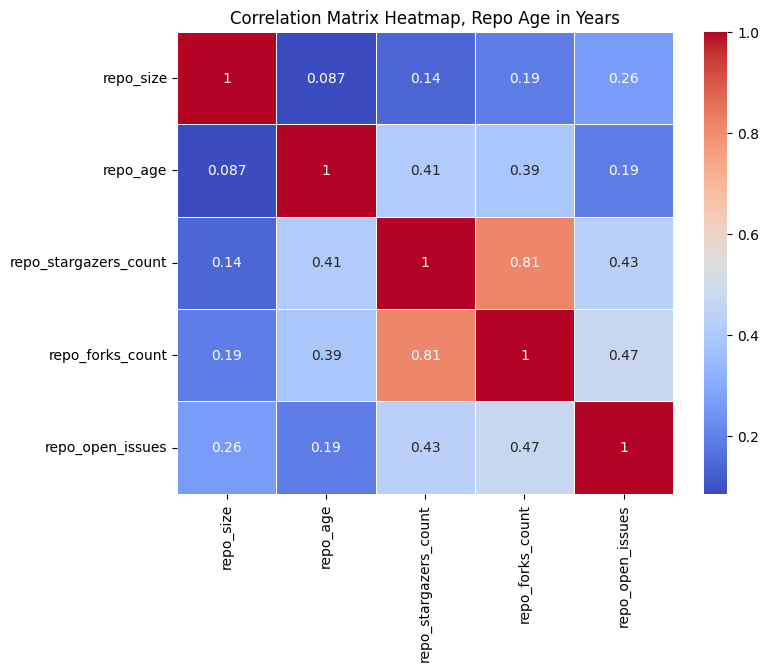

In [10]:
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap, Repo Age in Years')
plt.show()

### Linear Regression Function

In [11]:
def train_evaluate_explain(X, y, test_size=0.2, random_state=42):
    with PdfPages('filename.pdf') as pdf:
        print("\nAverage of y:", y.mean())
        
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Initialize and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Model details
        print("Model Intercept:", model.intercept_)
        model_details = f"Model Intercept: {model.intercept_:.4f}\n"
        for name, coef in zip(X_train.columns, model.coef_):
            print(f"{name}: {coef}")
            model_details += f"{name}: {coef:.4f}\n"
            
        # Function to evaluate model performance
        def evaluate_performance(y_true, y_pred, set_name="Test"):
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            performance_summary = (f'{set_name} Set - MSE: {mse:.4f}, '
                                   f'R^2: {r2:.4f}, MAE: {mae:.4f}\n')
            print(performance_summary)
            return performance_summary
        
        # Evaluate model performance
        y_pred_test = model.predict(X_test)
        performance_summary = evaluate_performance(y_test, y_pred_test, "Test")
        
        # Combine model details with performance summary
        full_summary = model_details + "\n" + performance_summary
        
        # Create a figure with the full summary
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
        ax.axis('off')
        ax.text(0.5, 0.5, full_summary, ha='center', va='center', fontsize=10, family='monospace')
        pdf.savefig(fig)
        plt.close()
        
        # SHAP Analysis
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        
        # Save SHAP summary plot (bar)
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        pdf.savefig()
        plt.close()
        
        
        # Save SHAP summary plot
        shap.summary_plot(shap_values, X_test, show=False)
        pdf.savefig()
        plt.close()
    
        # Feature Importance Plot
        shap.plots.bar(shap_values, show=False)
        pdf.savefig()
        plt.close()

        # Waterfall plot for the first prediction
        shap.plots.waterfall(shap_values[0], max_display=10, show=False)
        pdf.savefig()
        plt.close()

        # Scatter plot for the first feature
        shap.plots.scatter(shap_values[:, X_train.columns[0]], color=shap_values, show=False)
        pdf.savefig()
        plt.close()
        

        # Dependence plots for all features
        for feature in X_train.columns:
            shap.dependence_plot(feature, shap_values.values, X_test, interaction_index=None, show=False)
            pdf.savefig()
            plt.close()
        

        # Decision plot for a few predictions
        sample_indices = [0, 1, 2]
        shap.decision_plot(explainer.expected_value, shap_values.values[sample_indices], feature_names=X_train.columns.tolist(), show=False)

Baseline

In [ ]:
from sklearn.utils import shuffle

# Assuming 'filtered_df_copy' is your DataFrame and has been defined
X = filtered_df_copy.copy()
X = X.loc[:, ~X.columns.isin(['repo_full_name', 'repo_description', 'repo_language_No language'])]
y = filtered_df_copy['repo_open_issues']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the median of the target variable
median_y_train = y_train.median()

# Baseline predictions - use the median value of y_train for all predictions
baseline_predictions = np.full(shape=y_test.shape, fill_value=median_y_train)

# Evaluate the baseline
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))

# Calculate the R² score
baseline_r2 = r2_score(y_test, baseline_predictions)

# Print the evaluation results
print(f"Baseline MAE: {baseline_mae:.2f}")
print(f"Baseline RMSE: {baseline_rmse:.2f}\n")
print(f"Baseline R^2: {baseline_r2:.2f}")

In [ ]:
with PdfPages('filename.pdf') as pdf:  # Include the .pdf extension
    # Plotting the distribution of y_train
    plt.figure(figsize=(8, 6))
    plt.hist(y_train, bins=30, color='blue', alpha=0.7)
    plt.axvline(median_y_train, color='red', linestyle='dashed', linewidth=2)
    plt.title('Distribution of y_train with Median Value')
    plt.xlabel('Stargazer Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    # Add text page for evaluations
    plt.figure(figsize=(8, 6))
    text_str = f"""Baseline Evaluation Results:
    - Median of y_train: {median_y_train:.2f}
    - Baseline MAE: {baseline_mae:.2f}
    - Baseline RMSE: {baseline_rmse:.2f}
    - Baseline R^2: {baseline_r2:.2f}"""
    plt.text(0.5, 0.5, text_str, ha='center', va='center')
    plt.axis('off')
    pdf.savefig()
    plt.close()

Predicting Star Count

In [12]:
# Assume filtered_df_copy is your initial DataFrame with all data.
X = filtered_df_copy.copy()

# Remove non-feature columns you don't want in any model
X.drop(['repo_full_name', 'repo_description', 'repo_language_No language'], axis=1, inplace=True)

# Isolate the target variable 'y_stars' from the DataFrame
y_stars = X['repo_stargazers_count'].copy()

# Remove the target variable from X to avoid leakage
X.drop(['repo_stargazers_count'], axis=1, inplace=True)

# Now prepare X_stars by dropping additional columns not needed for the features
X_stars = X.drop(['repo_forks_count', 'repo_open_issues'], axis=1)

Predicting Fork Count

In [13]:
# Assume filtered_df_copy is your initial DataFrame with all data.
X = filtered_df_copy.copy()

# Remove non-feature columns you don't want in any model
X.drop(['repo_full_name', 'repo_description', 'repo_language_No language'], axis=1, inplace=True)

# Isolate the target variable 'y_stars' from the DataFrame
y_forks = X['repo_forks_count'].copy()

# Remove the target variable from X to avoid leakage
X.drop(['repo_forks_count'], axis=1, inplace=True)

# Now prepare X_stars by dropping additional columns not needed for the features
X_forks = X.drop(['repo_stargazers_count', 'repo_open_issues'], axis=1)

Predicting Open Issue Count

In [14]:
# Assume filtered_df_copy is your initial DataFrame with all data.
X = filtered_df_copy.copy()

# Remove non-feature columns you don't want in any model
X.drop(['repo_full_name', 'repo_description', 'repo_language_No language'], axis=1, inplace=True)

# Isolate the target variable 'y_stars' from the DataFrame
y_issues = X['repo_open_issues'].copy()

# Remove the target variable from X to avoid leakage
X.drop(['repo_open_issues'], axis=1, inplace=True)

# Now prepare X_stars by dropping additional columns not needed for the features
X_issues = X.drop(['repo_forks_count', 'repo_stargazers_count'], axis=1)

## Linear Regression

Stars

In [ ]:
train_evaluate_explain(X_stars,y_stars)

Forks

In [ ]:
train_evaluate_explain(X_forks,y_forks)

Issues

In [ ]:
train_evaluate_explain(X_issues,y_issues)

## Model Robust Framework Pipeline

#### Function Definitions

In [15]:
def model_baseline_framework(X, y, seeds, test_size=0.2, pdf_path='evaluation.pdf'):
    results = {
        'MSE': [],
        'RMSE': [],
        'MAE': [],
        'R_squared': []
    }

    with PdfPages(pdf_path) as pdf:
        for seed in seeds:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

            # Baseline predictions - use the median value of y_train for all predictions
            median_y_train = y_train.median()
            baseline_predictions = np.full(shape=y_test.shape, fill_value=median_y_train)

            # Collecting metrics
            mse = mean_squared_error(y_test, baseline_predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, baseline_predictions)
            r_squared = r2_score(y_test, baseline_predictions)

            results['MSE'].append(mse)
            results['RMSE'].append(rmse)
            results['MAE'].append(mae)
            results['R_squared'].append(r_squared)

        # Calculate mean and confidence intervals for metrics
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items()}

        # Include performance metrics in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

        # Simulated SHAP summary plot (this would normally be model-specific and not applicable directly to a baseline model)
        # Here, we assume an equal contribution for simplicity
        shap_values = np.ones(X_train.shape) * 0.1  # Simulating SHAP values
        shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
        fig = plt.gcf()  # Get the current figure
        pdf.savefig(fig)
        plt.close(fig)

    return summary

In [16]:
def model_evaluation_framework(model, X, y, seeds, test_size=0.2, model_type='linear', pdf_path='model_analysis_regression.pdf'):
    results = {
        'MSE': [],
        'RMSE': [],
        'MAE': [],
        'R_squared': [],
        'feature_importances': []
    }

    feature_names = X.columns.tolist()
    all_shap_values = []

    with PdfPages(pdf_path) as pdf:
        for seed in tqdm(seeds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
            
            # Fit the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Collecting metrics
            results['MSE'].append(mean_squared_error(y_test, y_pred))
            results['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            results['MAE'].append(mean_absolute_error(y_test, y_pred))
            results['R_squared'].append(r2_score(y_test, y_pred))

            # Feature importances if applicable
            if hasattr(model, 'feature_importances_'):
                results['feature_importances'].append(model.feature_importances_)
            elif hasattr(model, 'coef_'):
                results['feature_importances'].append(model.coef_[0])

            # SHAP analysis depending on model type
            if model_type in ['linear', 'ridge', 'lasso']:
                explainer = shap.LinearExplainer(model, X_train)
            elif model_type in ['decision_tree', 'xgboost', 'random_forest']:
                explainer = shap.TreeExplainer(model)
            else:
                continue  # Skip SHAP for unsupported model types
            
            shap_values = explainer.shap_values(X_train)
            all_shap_values.append(shap_values)

        # Calculate mean SHAP values and plot if applicable
        if all_shap_values:
            mean_shap_values = np.mean(all_shap_values, axis=0)
            fig, ax = plt.subplots()
            shap.summary_plot(mean_shap_values, X_train, plot_type="bar", show=False)
            pdf.savefig(fig)
            plt.close(fig)

        # Calculate mean and confidence intervals for metrics and feature importances
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items() if val}

        # Include performance metrics and feature importance CIs in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in ['MSE', 'RMSE', 'MAE', 'R_squared'] if key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

        if 'feature_importances' in summary:
            # Plot feature importances with confidence intervals
            feature_importance_means = np.mean(results['feature_importances'], axis=0)
            feature_importance_cis = np.percentile(results['feature_importances'], [2.5, 97.5], axis=0)
            error_bars = np.abs(feature_importance_cis - feature_importance_means[None, :])

            fig, ax = plt.subplots(figsize=(18, 12))
            ax.bar(feature_names, feature_importance_means, yerr=error_bars, capsize=5)
            ax.set_ylabel('Feature Importance')
            ax.set_title('Feature Importance with 95% CI')
            ax.set_xticks(range(len(feature_names)))
            ax.set_xticklabels(feature_names, rotation=90)
            pdf.savefig(fig)
            plt.close(fig)

    return summary

### Baseline

Stars

In [ ]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(X_stars, y_stars, seeds, pdf_path='baseline_eval_stars')
print(summary)

Forks

In [ ]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(X_forks, y_forks, seeds, pdf_path='baseline_eval_forks')
print(summary)

Issues

In [ ]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(X_issues, y_issues, seeds, pdf_path='baseline_eval_issues')
print(summary)

### Linear Regression

Stars

In [19]:
seeds = np.random.randint(20, 33, 10)
model = LinearRegression()
summary = model_evaluation_framework(model, X_stars, y_stars, seeds, model_type='linear', pdf_path='LR_stars_analysis.pdf')

Forks

In [20]:
seeds = np.random.randint(20, 33, 10)
model = LinearRegression()
summary = model_evaluation_framework(model, X_forks, y_forks, seeds, model_type='linear', pdf_path='LR_forks_analysis.pdf')

Issues

In [21]:
seeds = np.random.randint(20, 33, 10)
model = LinearRegression()
summary = model_evaluation_framework(model, X_issues, y_issues, seeds, model_type='linear', pdf_path='LR_issues_analysis.pdf')

### XGBoost

Stars

In [ ]:
seeds = np.random.randint(20, 33, 10)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
summary = model_evaluation_framework(model, X_stars, y_stars, seeds, model_type='xgboost', pdf_path='xgb_eval_stars.pdf')

Forks

In [ ]:
seeds = np.random.randint(20, 33, 10)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
summary = model_evaluation_framework(model, X_forks, y_forks, seeds, model_type='xgboost', pdf_path='xgb_eval_forks.pdf')

Issues

In [ ]:
seeds = np.random.randint(20, 33, 10)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
summary = model_evaluation_framework(model, X_issues, y_issues, seeds, model_type='xgboost', pdf_path='xgb_eval_issues.pdf')